In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchsummary import summary
import torch.nn.functional as F

# library to get dataloader
from dataloaders import get_pkmn_dataloader

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func,gradient_penalty,get_gradient

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout
from DiscriminatorPatchGAN import DiscriminatorPatchGAN,DiscriminatorPatchGANConditional
from DCGeneratorConditionalLarge import DCGeneratorConditionalLarge

from DCGeneratorConditional import DCGeneratorConditional
from DCGeneratorConditionalLarge import DCGeneratorConditionalLarge
from DCDiscriminatorConditional import DCDiscriminatorConditional
from DCDiscriminatorConditionalLarge import DCDiscriminatorConditionalLarge
from UNetArchitecture import UNet,UNetConditional,UNetConditionalImage
from StyleGanGenerator import MicroStyleGANGeneratorConditional,MicroStyleGANGenerator

# util methods
from utils import get_noise

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES,REDUCED_PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE_REDUCED

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))


torch.cuda.empty_cache()

Using device: cpu


In [2]:
print(torch.__version__)

# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None, use_uniform_transform = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    # We don't specifically need this since we are doing the denormalization ourself
    
    if denorm_transform is not None:
      assert use_uniform_transform == False
      image_tensor = denorm_transform(image_tensor)
    if use_uniform_transform:
      # cannot use both uniform and denorm transform together
      assert denorm_transform == None
      image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def save_model(model, output_filename):
  torch.save(model.state_dict(), output_filename)

1.10.2


In [4]:
z_dim = 128
out_chan = 3
truncation = 0.7

# 512 hidden channel si about 16m parameters
mu_stylegan = MicroStyleGANGeneratorConditional(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256,
    output_dim = 64
)

test_samples = 10
test_result = mu_stylegan(get_noise(test_samples, z_dim), torch.ones(test_samples, 1))

print(test_result.shape)

summary(mu_stylegan, [(1,128), (1,1)], device = 'cpu')

torch.Size([10, 3, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         150,528
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 1024]       1,049,600
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 496]         508,400
     MappingLayers-6                  [-1, 496]               0
            Conv2d-7            [-1, 256, 4, 4]       1,179,904
       InjectNoise-8            [-1, 256, 4, 4]             256
         LeakyReLU-9            [-1, 256, 4, 4]               0
   InstanceNorm2d-10            [-1, 256, 4, 4]               0
           Linear-11                  [-1, 256]         127,232
           Linear-12                  [-1, 256]         127,232
            AdaIN-13            [-1, 256, 4, 4]               0
MicroStyleG

In [5]:
# What are the differences here?
# PatchGan input is (3x96x96)
# output is 6x6 patches if input dim is 96
# output is 8x8 patches if input dim is 128
# Basically, it's easy to change the shape of the input dimension image, we just create more patches

test_patchgan = DiscriminatorPatchGANConditional(input_channels = 3, hidden_channels = 2)

patchgan_out = test_patchgan(torch.ones(7, 3, 96, 96), torch.ones(7, 1))

print("Shape of patchgan output is: {}".format(patchgan_out.shape))

summary(test_patchgan, [(3, 96, 96), (1,1)], device = 'cpu')

Shape of patchgan output is: torch.Size([7, 1, 6, 6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 16]             288
            Conv2d-2            [-1, 2, 96, 96]              10
   FeatureMapBlock-3            [-1, 2, 96, 96]               0
            Conv2d-4            [-1, 4, 96, 96]              76
         LeakyReLU-5            [-1, 4, 96, 96]               0
            Conv2d-6            [-1, 4, 96, 96]             148
         LeakyReLU-7            [-1, 4, 96, 96]               0
         MaxPool2d-8            [-1, 4, 48, 48]               0
  ContractingBlock-9            [-1, 4, 48, 48]               0
           Conv2d-10            [-1, 8, 48, 48]             296
      BatchNorm2d-11            [-1, 8, 48, 48]              16
        LeakyReLU-12            [-1, 8, 48, 48]               0
           Conv2d-13            [-1, 8, 48, 48]  

/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: can't multiply sequence by non-int of type 'tuple'

In [11]:
# ======= Define the basic hyper-parameters =====


# training epochs
n_epochs = 1

# # generator settings
z_dim = 32
map_hidden_dim = 1024
w_dim = 496
in_chan = 512
out_chan = 3
gen_kernel_size = 3
hidden_chan =  2

# discriminator settings
hidden_dim_disc = 2
disc_class_embed_size = 16


batch_size = 32
# how often to display images and debug info. Basically, the numerator is how many images you want to
# process before showing some debug info
display_step = int((4000 / batch_size))
periodic_saving = False
# after how many epochs do you save the model?
epoch_save_step = 1
save_prefix = "experiment_11/test_stylegan_unconditional"
imgs_to_display = 10

print("Planning to display images every {} steps".format(display_step))

# other sources say 0.00275 works better...but the DCGAn paper used 0.0002 (ie. about 10-4 instead of 10-3)
gen_lr = 0.0002 # 0.0002 works for both, but takes at least 10-15 epochs before anything interesting happens?
disc_lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
disc_repeats = 1
gen_repeats = 1

# loss functions
use_wgan_loss = False
if use_wgan_loss:
  gen_loss_func = get_generator_loss_func("wgan_gen_loss")
  disc_loss_func = get_disc_loss_func("wgan_disc_loss")
  c_lambda = 10
else:
  gen_loss_func = get_generator_loss_func("basic_gen_loss_with_logits")
  disc_loss_func = get_disc_loss_func("noisy_patchgan_disc_loss")

assert imgs_to_display <= batch_size

Planning to display images every 125 steps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of dataset (number of steps) is: 231, total size is: 7392


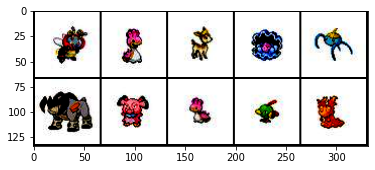

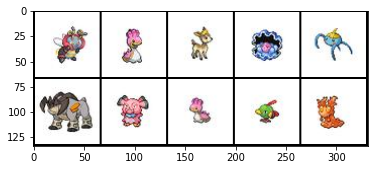

In [9]:
# Create the dataloader, based on the appropriate batch size. 

use_reduced_types = True
show_preview = True
dataloader_name = "conditional_64_no_shiny_mainclass_flip_rotate_standard_norm"

pkmn_dataloader, denorm_transform = get_pkmn_dataloader(dataloader_name, batch_size,num_workers=0)
test_size = 10

# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("length of dataset (number of steps) is: {}, total size is: {}".format(len(pkmn_dataloader), len(pkmn_dataloader)*batch_size))

if show_preview:
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = None)
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = denorm_transform)

if use_reduced_types:
  valid_types = REDUCED_PKMN_TYPES
  class_idx_to_type = CLASS_IDX_2_PKMN_TYPE_REDUCED
else:
  valid_types = PKMN_TYPES
  class_idx_to_type = CLASS_IDX_2_PKMN_TYPE
  
num_pkmn_types = len(valid_types)

In [15]:
# Create the generator/discriminator and use them
# layer initialization for Generator and Discriminator (for Conv2d and ConvTranpose2d)

gen = MicroStyleGANGeneratorConditional(
    z_dim=z_dim, 
    map_hidden_dim=map_hidden_dim,
    w_dim=w_dim,
    in_chan=in_chan,
    out_chan=out_chan, 
    kernel_size=gen_kernel_size, 
    hidden_chan=hidden_chan,
    use_class_embed = False,
    class_embed_size = 16,
    output_dim = 64
).to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=gen_lr, betas=(beta_1, beta_2))
disc = DiscriminatorPatchGANConditional(hidden_channels = hidden_dim_disc, 
                                        use_dropout = True, 
                                        input_image_dim = 64,
                                        dropout_prob = 0.5).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=disc_lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


  0%|          | 0/231 [00:00<?, ?it/s]

Step 125: Epoch: 0: Generator loss: 0.6746736731529236, discriminator loss: 0.6933531823158264 mean disc pred on real images: 0.5094324350357056, fake images: 0.5094277858734131


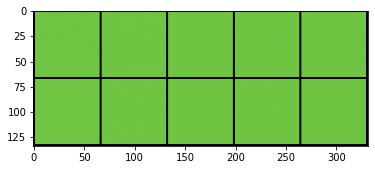

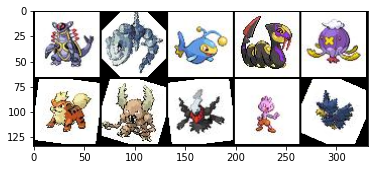

Pokemon types we are trying to generate are: ['Rock', 'Steel', 'Water', 'Poison', 'Ghost'] 
    	 	 	 	 	 ['Fire', 'Bug', 'Ghost', 'Fighting', 'Ghost']


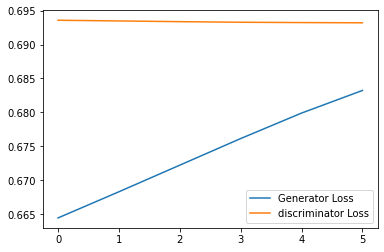

/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [16]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

cur_step = 0
generator_losses = []
discriminator_losses = []
discriminator_fake_preds = [] # median value of P(real) the discriminator predicts on the fake images (per batch)
discriminator_real_preds = [] # median value of P(real) the discriminator predicts on the real images (per batch)
sigmoid_function = nn.Sigmoid() # use this if you have logit outputs

for epoch in range(n_epochs):
    # Dataloader returns the (real_images, labels)
    for real, true_labels in tqdm(pkmn_dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        true_labels = true_labels.to(device)
        
        mean_iteration_discriminator_loss = 0
        for _ in range(disc_repeats):
            ### Update discriminator ###
            disc_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise, true_labels)
            
            disc_fake_pred = disc(fake.detach(), true_labels)
            disc_real_pred = disc(real, true_labels)

            
            if use_wgan_loss:
              epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
              gradient = get_gradient(disc, real, true_labels, fake.detach(), epsilon)
              gp = gradient_penalty(gradient)
              # how should we track these two relative losses ?
              disc_loss = disc_loss_func(disc_fake_pred, disc_real_pred, gp, c_lambda)              

            else:
              # compute discriminator loss normally
              disc_loss = disc_loss_func(disc_fake_pred, disc_real_pred, device)
            
            # Keep track of the average discriminator loss in this batch
            mean_iteration_discriminator_loss += disc_loss.item() / disc_repeats
            
            # Update gradients
            # when using WGAN, we have retain_graph = True, but it probably takes longer
            disc_loss.backward(retain_graph=use_wgan_loss)
            
            # Update optimizer
            disc_opt.step()
            
        discriminator_losses += [mean_iteration_discriminator_loss]
        # notice this only takes the last one from the iteration (if you run the discriminator multiple times)
        # use a Sigmoid here to go from logits back into the P(real) space
        discriminator_fake_preds += [sigmoid_function(torch.mean(disc_fake_pred).detach())]
        discriminator_real_preds += [sigmoid_function(torch.mean(disc_real_pred).detach())]

        ### Update generator ###
        mean_iteration_gen_loss = 0
        for _ in range(gen_repeats):
          gen_opt.zero_grad()
          fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
          fake_2 = gen(fake_noise_2, true_labels)
          disc_fake_pred = disc(fake_2, true_labels)

          # compute gen loss
          gen_loss = gen_loss_func(disc_fake_pred, device)
          
          mean_iteration_gen_loss += gen_loss.item() / gen_repeats
          
          gen_loss.backward()

          # Update the weights
          gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [mean_iteration_gen_loss]
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            # maybe print out the last values here ? To see how stable it is overtime ? These all seem to be very close to 0.5 / 1
            disc_prediction_real = sum(discriminator_real_preds[-display_step:]) / display_step
            disc_prediction_fake = sum(discriminator_fake_preds[-display_step:]) / display_step
            print(f"Step {cur_step}: Epoch: {epoch}: Generator loss: {gen_mean}, discriminator loss: {disc_mean} mean disc pred on real images: {disc_prediction_real}, fake images: {disc_prediction_fake}")
            show_tensor_images(fake[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            show_tensor_images(real[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            
            ground_truth_types = [class_idx_to_type[class_idx] for class_idx in true_labels[0:imgs_to_display].cpu().numpy()]
            print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(ground_truth_types[0:5], ground_truth_types[5:]))
            
            step_bins = 20
            
            # todo: add proper labels to this plot
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="discriminator Loss"
            )
            plt.legend()
            plt.show()
        
        # increase the current step (ie. one batch)
        cur_step += 1
        
    if periodic_saving and epoch % epoch_save_step == 0 and epoch_save_step > 0:
      outfile_name = "{}_{}.pt".format(save_prefix, cur_step)
      print("===== Saving intermediate model with name {} ! ====".format(outfile_name))
      save_model(gen, outfile_name)

In [ ]:
# Save the final model

out_file = "second_gan_with_standard_dcgan_arch_after_149epochs.pt"
  
save_model(gen, out_file)

In [ ]:
# Load model for inference and generate some random classes

gen.load_state_dict(torch.load("{}".format(out_file)))

# Performing inference - actually, maybe I ran some other cell after this so it's not really well defined
num_samples = 10

sample_vector = get_noise(num_samples, z_dim, device)
random_classes = torch.randint(low = 0, high = NUM_PKMN_TYPES, size = (num_samples,)).to(device)

fake_images = gen(sample_vector, random_classes)

output_size = gen.output_dim
# + 0.9
show_tensor_images(fake_images, num_images=num_samples, size=(1,256, 256), use_uniform_transform = True, denorm_transform = None)


pkmn_classes = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in random_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:]))

In [ ]:
# Generate samples of a specific type from the model
target_type = "Fire"
class_idx = PKMN_TYPES.index(target_type)

class_tiled = torch.from_numpy(np.array([class_idx] * num_samples))

sample_vector = get_noise(num_samples, z_dim, device)
classes = class_tiled.to(device)

fake_images = gen(sample_vector, classes)

output_size = gen.output_dim
# + 0.9
show_tensor_images(fake_images, num_images=num_samples, size=(1,256, 256), use_uniform_transform = True, denorm_transform = None)


pkmn_classes = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:]))
